# Graph Analysis

### Connect with database

In [14]:
from neo4j import GraphDatabase

URI = "neo4j://localhost:7687"
NAME_DB = "movies"

driver = GraphDatabase.driver(URI)

driver.verify_connectivity()

print("Successfully connected to Neo4j")

Unable to retrieve routing information


ServiceUnavailable: Unable to retrieve routing information

In [ ]:
session = driver.session()

if [NAME_DB] in session.run("SHOW DATABASE yield name;").values():
    print("Database already exists")
else:
    session.run(f"CREATE DATABASE {NAME_DB};")
    print("Database created")
session = driver.session(database=NAME_DB)

Database already exists


### Create constraints

In [ ]:
# TODO: maybe add constraints for id for edges
session.run(
    """
    CREATE CONSTRAINT UniqueMovieID IF NOT EXISTS 
    FOR (m:Movie) 
    REQUIRE m.id IS unique;
    """
)
session.run(
    """
    CREATE CONSTRAINT UniqueUserID IF NOT EXISTS 
    FOR (u:User) 
    REQUIRE u.id IS unique;
    """
)
# TODO: add constraints for relationships

### Add nodes to database

In [ ]:
session.run(
    """
LOAD CSV WITH HEADERS
FROM "file:///users.csv" AS row
RETURN row LIMIT 10
"""
)

In [ ]:
session.run(
    """
    LOAD CSV WITH HEADERS 
    FROM "file:///users.csv" AS row
    MERGE (u:User {id: toInteger(row.userId)})
    SET u.ratings = toInteger(row.ratings),
        u.tags = toInteger(row.tags);
    """
)
session.run(
    """
    LOAD CSV WITH HEADERS 
    FROM "file:///genres.csv" AS row
    MERGE (g:Genre {id: toInteger(row.genreId)})
    SET g.name = row.name;
    """
)
session.run(
    """
    LOAD CSV WITH HEADERS 
    FROM "file:///movies.csv" AS row
    MERGE (m:Movie {id: toInteger(row.movieId)})
    SET m.title = row.title,
        m.year = toInteger(row.year);
    """
)

In [ ]:
# TODO: Create indexes with sense
# session.run(
#     """
#     CREATE INDEX MovieTitleIndex FOR (m:Movie) ON (m.title);
#     """
# )
# session.run(
#     """
#     CREATE INDEX MovieGenresIndex FOR (m:Movie) ON (m.genres);
#     """
# )

In [ ]:
session.run(
    """
    LOAD CSV WITH HEADERS FROM "file:///ratings.csv" AS row
    CALL {
        WITH row
        MATCH (m:Movie {id: toInteger(row.movieId)})
        MATCH (u:User {id: toInteger(row.userId)})
        MERGE (u)-[r:RATED]->(m)
        SET r.rating = toFloat(row.rating),
        r.timestamp = datetime({epochSeconds:toInteger(row.timestamp)})
    } IN TRANSACTIONS OF 100000 ROWS;
    """
)

session.run(
    """
    LOAD CSV WITH HEADERS FROM "file:///tags.csv" AS row
    CALL {
        WITH row
        MATCH (m:Movie {id: toInteger(row.movieId)})
        MATCH (u:User {id: toInteger(row.userId)})
        MERGE (u)-[t:TAGGED]->(m)
        SET t.tag = row.tag,
        t.timestamp = datetime({epochSeconds:toInteger(row.timestamp)})
    } IN TRANSACTIONS OF 100000 ROWS;
    """
)
session.run(
    """
    LOAD CSV WITH HEADERS FROM "file:///movies_genres.csv" AS row
    MATCH (m:Movie {id: toInteger(row.movieId)})
    MATCH (g:Genre {id: toInteger(row.genreId)})
    MERGE (m)-[in_g:IN_GENRE]->(g);
    """
)

KeyboardInterrupt: 

In [ ]:
from graphdatascience import GraphDataScience

gds = GraphDataScience(URI, aura_ds=False, database=NAME_DB)
# total node counts
gds.run_cypher(
    """
    CALL apoc.meta.stats()
    YIELD labels AS nodeCounts
    UNWIND keys(nodeCounts) AS label
    WITH label, nodeCounts[label] AS nodeCount
    WHERE label IN ['User','Movie','Genre']
    RETURN label, nodeCount
"""
)

/home/angelo-dev/miniconda3/envs/data_science/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


,label,nodeCount
0,Movie,9742
1,User,610
2,Genre,20


In [ ]:
gds.run_cypher(
    """
    CALL apoc.meta.stats()
    YIELD relTypesCount as relationshipCounts
    UNWIND keys(relationshipCounts) AS type
    WITH type, relationshipCounts[type] AS relationshipCount
    WHERE type IN ['RATED','TAGGED','IN_GENRE']
    RETURN type, relationshipCount
"""
)

,type,relationshipCount
0,TAGGED,1775
1,IN_GENRE,22084
2,RATED,100836


In [ ]:
from typing import Union
import pandas as pd
import numpy as np


# Helper functions (https://github.com/zach-blumenfeld/demo-news-recommendation/blob/main/mind-large-collab-filtering/practical-graph-recommendation-cf-example.ipynb)
class GraphQueryError(Exception):
    def __init__(self, message):
        self.message = message


def run(driver, query, params=None):
    with driver.session() as session:
        if params is not None:
            return [r for r in session.run(query, params)]
        else:
            return [r for r in session.run(query)]


def degree_counts(
    node_label: str,
    relationship_type: str,
    direction: Union["IN", "OUT", "BOTH"] = "IN",
):

    match = f"(n:{node_label}) {'<' if direction in ['IN', 'BOTH'] else ''}-[:{relationship_type}]-{'>' if direction in ['OUT', 'BOTH'] else ''}()"

    df = gds.run_cypher(
        f"""
            MATCH {match}
            RETURN n.id as id,COUNT(*) AS degreeCount
            ORDER BY degreeCount DESC;
        """
    )
    return df


def get_percentiles(df, q=None):
    if q is None:
        q = [0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99]
    q_name = ["min"] + [f"p{int(100*i)}" for i in q] + ["max"]
    p = [df.min()] + [df[df.percentile >= i].iloc[0] for i in q] + [df.degree.max()]
    p_df = pd.DataFrame(np.column_stack((q_name, p)), columns=["q", "percentile"])
    return p_df.set_index("q")

<Axes: >

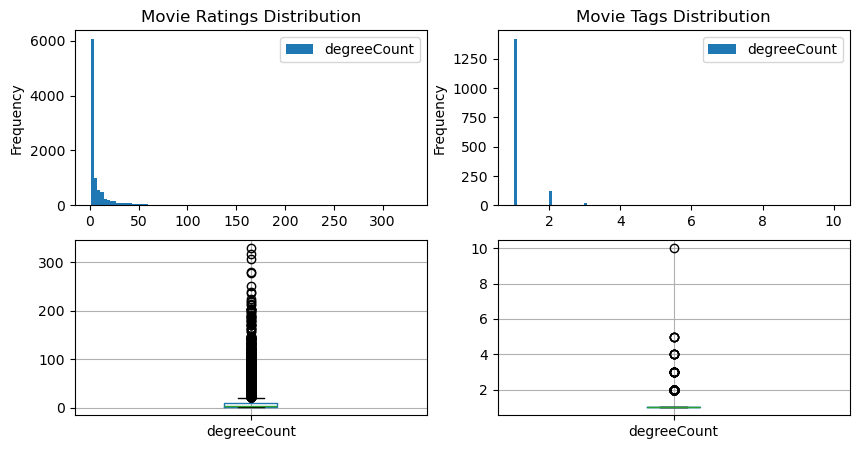

In [ ]:
import matplotlib.pyplot as plt

all_ratings_df = degree_counts("Movie", "RATED", "IN")
all_tags_df = degree_counts("Movie", "TAGGED", "IN")
all_genres_df = degree_counts("Genre", "IN_GENRE", "IN")

# plot disributions
f, axs = plt.subplots(2, 2, figsize=(10, 5))

all_ratings_df.plot(
    x="id",
    y="degreeCount",
    kind="hist",
    ax=axs[0, 0],
    title="Movie Ratings Distribution",
    bins=100,
)
all_tags_df.plot(
    x="id",
    y="degreeCount",
    kind="hist",
    ax=axs[0, 1],
    title="Movie Tags Distribution",
    bins=100,
)

all_ratings_df.boxplot(column="degreeCount", ax=axs[1, 0])
all_tags_df.boxplot(column="degreeCount", ax=axs[1, 1])

In [ ]:
all_ratings_df

,id,degreeCount
0,356,329
1,318,317
2,296,307
3,593,279
4,2571,278
...,...,...
9719,152270,1
9720,152284,1
9721,152372,1
9722,152591,1
